# Regularized gradient descent GAN optimization
*Thomas Viehmann* <tv@lernapparat.de>

This is a pytorch adaptation of a toy problem in the [code](https://github.com/locuslab/gradient_regularized_gan/blob/master/gaussian-toy-regularized.py) accompanying
[V. Nagarajan, J.Z. Kolter: Gradient descent GAN optimization is locally stable](https://arxiv.org/abs/1706.04156).

This notebook regularizes the generator gradient descent for the vanilla (DCGAN) GAN.

In the paper's notation the score function (minimized by G and maximized by D) is defined as
$$
V(\theta_G, \theta_D) := E_{x\sim p_{data}}[f(D(x))]+E_{z \sim p_{noise}}[f(-D(G(z))].
$$
In our case the of vanilla GAN, the logsigmoid scoring function $f:=-\log(1+exp(-x))$, see the python function `score` below.
Note that this is equivalent to the [`binary_cross_entropy with logits`](http://pytorch.org/docs/master/nn.html#torch.nn.functional.binary_cross_entropy_with_logits) function with a target indicating "realness" - the formulation the original code uses.

As usual, $\theta_G$ and $\theta_D$ denote the generator's and discriminator's parameters and the expectations are actually sampled in minibatches in the stochastic updates.

The authors propose to replace the vanilla GAN generator loss $V$ by the regularized
$$
\tilde V := V + \eta \| \nabla_{\theta_D} V \|^2 
$$
and train the generator and the discriminator with alternating single steps.
This is done below.


In [1]:
import itertools
import types
%matplotlib inline
import seaborn
from matplotlib import pyplot
import torch
from torch.autograd import Variable
import IPython
import numpy

In [2]:
def sample_mog(batch_size, n_mixture=8, std=0.02, radius=2.0):
    thetas = torch.arange(0, 2*numpy.pi, 2*numpy.pi/n_mixture, out=torch.cuda.FloatTensor())
    centers = torch.stack([radius * torch.sin(thetas), radius * torch.cos(thetas)],dim=1)
    cat = torch.distributions.Categorical(torch.cuda.FloatTensor(1,n_mixture).fill_(1.0)).sample_n(batch_size).squeeze(1)
    sample = torch.cuda.FloatTensor(batch_size,2).normal_()*std+centers[cat]
    return sample
 

In [3]:
params = types.SimpleNamespace()
for k,v in dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=100001,
    viz_every=1000,
    z_dim=256,
    x_dim=2,
    unrolling_steps=0,
    regularizer_weight=0.5,
  ).items():
  setattr(params,k,v)


In [4]:
class Generator(torch.nn.Sequential):
    def __init__(self, input_dim=params.z_dim, output_dim=2, n_hidden=128, n_layer=2):
        super().__init__(*(sum(([torch.nn.Linear((input_dim if i==0 else n_hidden), n_hidden),
                              torch.nn.ReLU()] for i in range(n_layer)),[])
                             +[torch.nn.Linear(n_hidden, output_dim)]))

class Lambda(torch.nn.Module):
    def __init__(self, lam):
        super().__init__()
        self.lam = lam
    def forward(self, *x):
        return self.lam(*x)

# I don't know why the /4 is strictly necessary... Just copying locuslab's version
class Discriminator(torch.nn.Sequential):
    def __init__(self, input_dim=2, n_hidden=128, n_layer=1):
        super().__init__(*([Lambda(lambda x: x/4.0)]
                           +sum(([torch.nn.Linear((input_dim if i==0 else n_hidden), n_hidden),
                                  torch.nn.ReLU()] for i in range(n_layer)),[])
                           +[torch.nn.Linear(n_hidden, 1)]))

generator = Generator()
discriminator = Discriminator()
generator.cuda()
discriminator.cuda()

for p in itertools.chain(generator.parameters(), discriminator.parameters()):
    if p.data.dim()>1:
        torch.nn.init.orthogonal(p, 0.8)
#with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=0.8)):

def score(real_score, fake_score):
    # D maximizes this, G minimizes this + a regularizer
    return torch.nn.functional.logsigmoid(real_score).mean()+torch.nn.functional.logsigmoid(-fake_score).mean()

d_opt = torch.optim.Adam(discriminator.parameters(), lr=params.disc_learning_rate, betas = (params.beta1,0.999), eps=params.epsilon)
g_opt = torch.optim.Adam(generator.parameters(), lr=params.gen_learning_rate, betas = (params.beta1,0.999), eps=params.epsilon)
all_d_gr_norms = []
all_scores = []

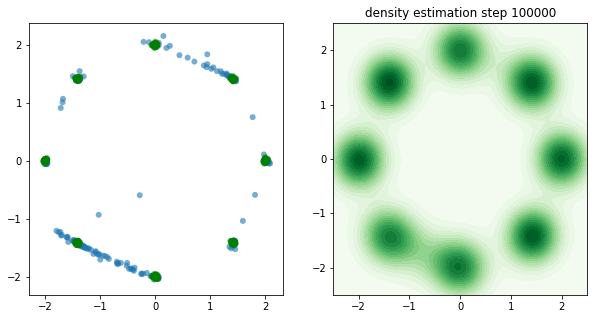

1.3844473361968994 0.0019108541309833527 -1.3844239711761475


In [5]:
for i in range(params.max_iter):
    noise = Variable(torch.cuda.FloatTensor(params.batch_size, params.z_dim).normal_())
    real_data = Variable(sample_mog(params.batch_size))
    
    # Discriminator update
    generator.eval()
    discriminator.train()

    fake_data = generator(noise).detach()
    fake_score = discriminator(fake_data)
    real_score = discriminator(real_data)
    d_scores = -score(real_score, fake_score)    
    d_opt.zero_grad()
    d_scores.backward()
    d_opt.step()

    # Generator Update
    generator.train()
    discriminator.eval()
    
    fake_data = generator(noise)
    fake_score = discriminator(fake_data)
    real_score = discriminator(real_data)
    scores = score(real_score, fake_score)

    grads = torch.autograd.grad(scores, discriminator.parameters(), retain_graph=True, create_graph=True)
    gr_norm_sq = 0.0
    for gr in grads:
        gr_norm_sq += (gr**2).sum()

    all_scores.append(scores.data[0])
    all_d_gr_norms.append(gr_norm_sq.data[0]**0.5)

    g_loss = scores+params.regularizer_weight*gr_norm_sq

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if i % params.viz_every == 0:
        IPython.display.clear_output(True)
        pyplot.figure(figsize=(10,5))
        pyplot.subplot(1,2,1)
        xx = fake_data.data.cpu().numpy()
        yy = real_data.data.cpu().numpy()
        pyplot.scatter(xx[:, 0], xx[:, 1], edgecolor='none',alpha=0.6)
        pyplot.scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none', alpha=0.6)
        pyplot.subplot(1,2,2)
        generator.eval()
        noise = Variable(torch.cuda.FloatTensor(params.batch_size*10, params.z_dim).normal_(), volatile=True)
        fake_data = generator(noise)
        fake_data_cpu = fake_data.data.cpu().numpy()
        seaborn.kdeplot(fake_data_cpu[:, 0], fake_data_cpu[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-2.5,2.5]]*2)
        pyplot.gca().set_facecolor(seaborn.color_palette('Greens', n_colors=256)[0])
        pyplot.title('density estimation step %d'%i)
        pyplot.show()
        print(d_scores.data[0], gr_norm_sq.data[0], scores.data[0])





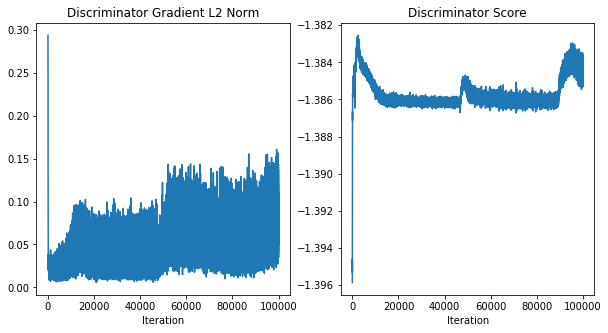

In [6]:
pyplot.figure(figsize=(10,5))        
pyplot.subplot(1,2,1)
pyplot.title('Discriminator Gradient L2 Norm')
pyplot.xlabel('Iteration')
pyplot.plot(all_d_gr_norms)
pyplot.subplot(1,2,2)
pyplot.title('Discriminator Score')
pyplot.xlabel('Iteration')
pyplot.plot(all_scores);

I hope this notebook is useful for you. I appreciate your feedback and read every mail.

Thomas Viehmann <tv@lernapparat.de>
